# Connect to dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2 as cv
import random

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
def random_load_image_from_directory(directory, num_images=10):
  images = []
  for filename in os.listdir(directory):
    img = cv.imread(os.path.join(directory, filename))
    images.append(img)

  return random.sample(images, min(num_images, len(images)))

In [40]:
def get_list_of_files(directory):
  allFiles = []
  for root, dirs, files in os.walk(directory):
    for file in files:
        fullPath = os.path.join(root, file)
        allFiles.append(fullPath)
  return allFiles

# Image Preprocessing

In [6]:
import matplotlib.pyplot as plt

## Background Remover Binary

In [41]:
def background_remover(image):
  if not isinstance(image, str) or not os.path.exists(image):
    raise ValueError(f"Invalid file path: {image}")
  image = cv.imread(image)
  hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

  saturation = hsv_image[:, :, 1]
  _, binary_mask = cv.threshold(saturation, 85, 255, cv.THRESH_BINARY)
  masked_image = cv.bitwise_and(image, image, mask=binary_mask)
  return masked_image

### Validation BG Remover

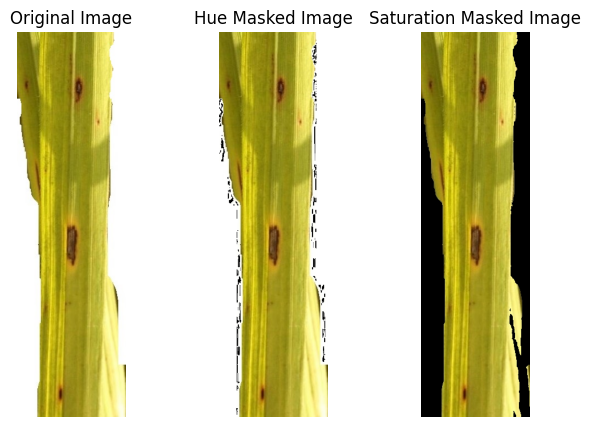

(-0.5, 196.5, 698.5, -0.5)

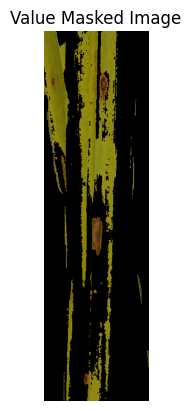

In [ ]:
BG_remove_image = cv.imread("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Blast/DSC_0109.jpg")

hsv_image = cv.cvtColor(BG_remove_image, cv.COLOR_BGR2HSV)

hue = hsv_image[:, :, 0]
saturation = hsv_image[:, :, 1]
value = hsv_image[:, :, 2]

_, hue_binary_mask = cv.threshold(hue, 50, 255, cv.THRESH_BINARY_INV)
_, saturation_binary_mask = cv.threshold(saturation, 100, 255, cv.THRESH_BINARY)
_, value_binary_mask = cv.threshold(value, 150, 255, cv.THRESH_BINARY_INV)

hue_masked_image = cv.bitwise_and(BG_remove_image, BG_remove_image, mask=hue_binary_mask)
saturation_masked_image = cv.bitwise_and(BG_remove_image, BG_remove_image, mask=saturation_binary_mask)
value_masked_image = cv.bitwise_and(BG_remove_image, BG_remove_image, mask=value_binary_mask)

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(cv.cvtColor(BG_remove_image, cv.COLOR_BGR2RGB))

plt.subplot(1, 4, 2)
plt.title("Hue Masked Image")
plt.imshow(cv.cvtColor(hue_masked_image, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Saturation Masked Image")
plt.imshow(cv.cvtColor(saturation_masked_image, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

plt.subplot(1, 4, 4)
plt.title("Value Masked Image")
plt.imshow(cv.cvtColor(value_masked_image, cv.COLOR_BGR2RGB))
plt.axis("off")

# Calculate optimal cluster

In [8]:
from sklearn.cluster import KMeans

In [ ]:
test_image = background_remover("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Brown_Spot/Brown_spot_09.PNG")
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

## Elbow Within Cluster Sum of Square Method

### EW for 1 image

In [9]:
def calculate_wcss(image, max_k=10):
    wcss = []
    pixel_values = image.reshape((-1, 3))
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        wcss.append(kmeans.inertia_)
    return wcss

In [ ]:
wcss = calculate_wcss(test_image, max_k=10)

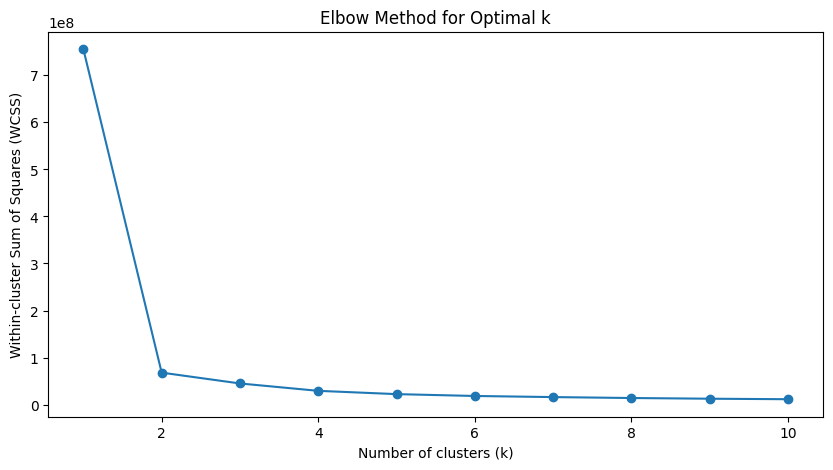

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

### EW for multi image

In [10]:
def calculate_multi_image_wcss(images, max_k=10):
    wcss = []
    pixel_values = np.vstack([img.reshape((-1, 3)) for img in images])
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        wcss.append(kmeans.inertia_)
    return wcss

In [ ]:
wcss = calculate_multi_image_wcss(random_bacterial_blight, max_k=10)


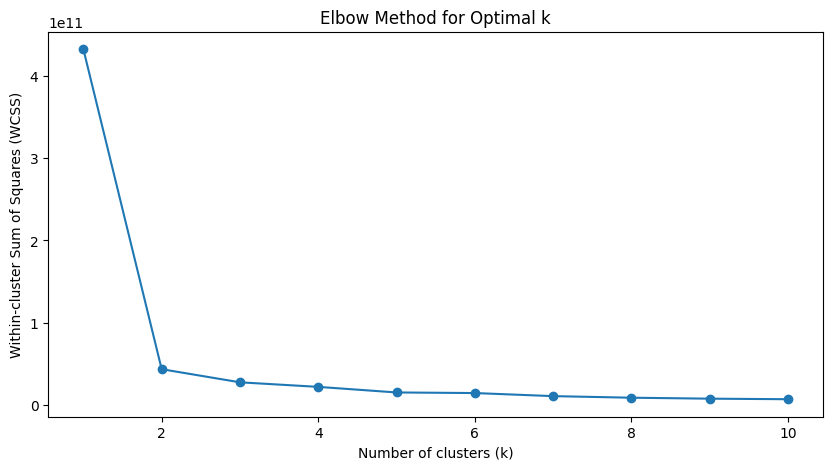

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

## Gap Statistic Method

In [88]:
from sklearn.metrics import pairwise_distances

In [11]:
def find_optimal_k(gaps, s_k):
    for k in range(1, len(gaps)):
        if gaps[k-1] >= gaps[k] - s_k[k]:
            return k
    return len(gaps)

### GS Single Image

In [90]:
def gap_statistic_for_k(args):
    pixel_values, k, n_refs = args
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixel_values)

    disp = np.sum(np.min(pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))

    ref_disps = np.zeros(n_refs)
    for i in range(n_refs):
        random_reference = np.random.uniform(
            low=pixel_values.min(axis=0),
            high=pixel_values.max(axis=0),
            size=pixel_values.shape
        )
        kmeans.fit(random_reference)
        ref_disps[i] = np.sum(np.min(pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))

    log_ref_disp = np.log(ref_disps)
    gap = np.mean(log_ref_disp) - np.log(disp)
    s_k = np.sqrt(np.sum((log_ref_disp - np.mean(log_ref_disp))**2) / n_refs)
    return k, gap, s_k

def calculate_gap_statistic_parallel(image, max_k=10, n_refs=10, num_workers=2):
    pixel_values = image.reshape((-1, 3))
    args = [(pixel_values, k, n_refs) for k in range(1, max_k + 1)]

    with multiprocessing.Pool(processes=num_workers) as pool:
        results = pool.map(gap_statistic_for_k, args)

    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)
    for k, gap, sk in results:
        gaps[k-1] = gap
        s_k[k-1] = sk

    return gaps, s_k

In [ ]:
gaps, s_k = calculate_gap_statistic_parallel(test_image, max_k=5, n_refs=10, num_workers=2)

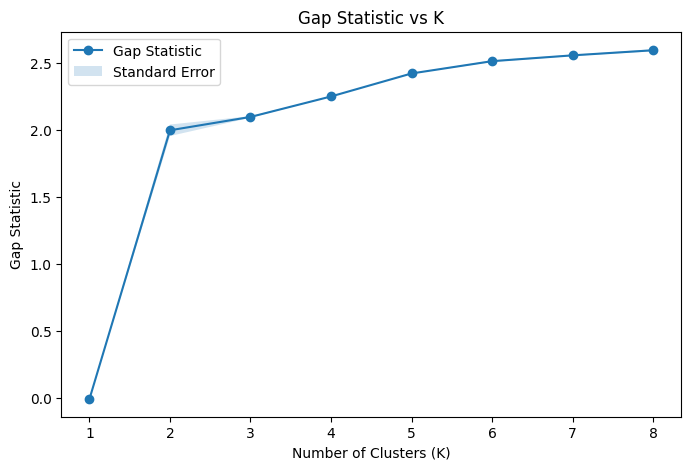

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(gaps) + 1), gaps, marker='o', label='Gap Statistic')
plt.fill_between(range(1, len(gaps) + 1), gaps - s_k, gaps + s_k, alpha=0.2, label='Standard Error')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs K')
plt.legend()
plt.show()

In [ ]:
optimal_k = find_optimal_k(gaps, s_k)
print(f"The optimal number of clusters (K) is: {optimal_k}")

The optimal number of clusters (K) is: 8


### GS Multi Images

In [ ]:
def multi_calculate_gap_statistic(images, max_k=10, n_refs=10):
    pixel_values = np.vstack([img.reshape((-1, 3)) for img in images])
    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        disp = np.mean(
            np.min(
                pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean'), axis=1
            )
        )
        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            random_reference = np.random.random_sample(size=pixel_values.shape)
            kmeans.fit(random_reference)
            ref_disp = np.mean(
                np.min(
                    pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean'), axis=1
                )
            )
            ref_disps[i] = ref_disp
        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps[k - 1] = gap
        s_k[k - 1] = np.sqrt(
            np.mean((np.log(ref_disps) - np.log(np.mean(ref_disps)))**2)
        )

    return gaps, s_k

In [ ]:
gaps, s_k = calculate_gap_statistic(random_bacterial_blight, max_k=8)

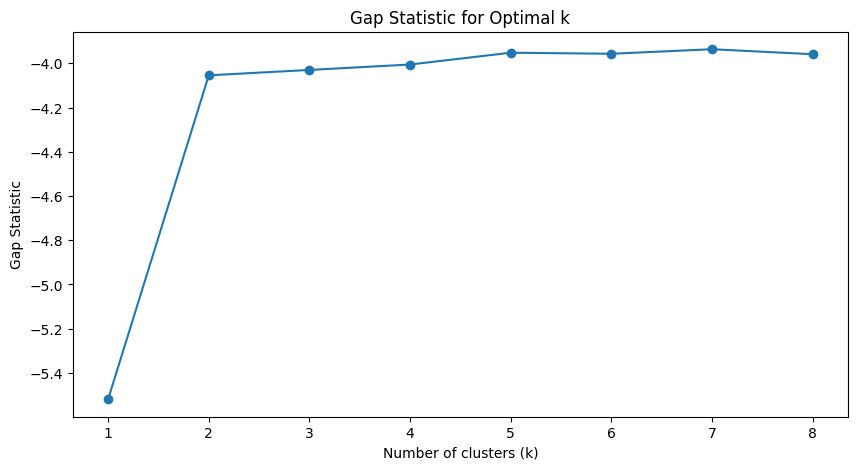

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(gaps) + 1), gaps, marker='o', label='Gap Statistic')

plt.errorbar(range(1, len(gaps) + 1), gaps, yerr=s_k, fmt='o', color='black', label='Standard Deviation')

optimal_k = np.argmax(gaps) + 1
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')

plt.title('Gap Statistic vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Gap Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimal_k = np.argmax(gaps) + 1
print(f'The optimal number of clusters is: {optimal_k}')

The optimal number of clusters is: 7


# K mean segmentation






In [13]:
import numpy as np

In [12]:
def k_mean_segmentation(disease, attempts=10, K=2):
  disease = cv.cvtColor(disease, cv.COLOR_BGR2RGB)
  leaf_image = disease.reshape((-1,3))
  leaf_image = np.float32(leaf_image)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret, labels, centers = cv.kmeans(leaf_image, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

  centers = np.uint8(centers)
  segmented_image = centers[labels.flatten()]
  segmented_image = segmented_image.reshape((disease.shape))

  return segmented_image, labels, centers

def segment_image(args):
    disease, K = args
    return k_mean_segmentation(disease, K=K)

def parallel_segmentation(images, K=2, num_workers=2):
    args = [(img, K) for img in images]
    with multiprocessing.Pool(processes=num_workers) as pool:
        results = pool.map(segment_image, args)
    return results

In [42]:
def mask_filter(image, segmented_image, cluster, labels):
  mask = (labels.flatten() == cluster)
  filtered_image = np.zeros_like(segmented_image)
  filtered_image[mask.reshape(image.shape[:2])] = segmented_image[mask.reshape(image.shape[:2])]
  return filtered_image

# Post Clustering

In [ ]:
diseased_portion_image = mask_filter(test_image, segmented_test_image, 3, test_labels)
diseased_portion_image = cv.cvtColor(diseased_portion_image, cv.COLOR_RGB2HSV)
mean_hsv = cv.mean(diseased_portion_image)[:3]
print(mean_hsv)
plt.figure(figsize=(10, 5))
plt.imshow(diseased_portion_image)
plt.axis("off")
plt.show()

In [17]:
def normalize_hsv(hsv_value):
    hue, saturation, value = hsv_value
    hue_normalized = hue / 180.0
    saturation_normalized = saturation / 255.0
    value_normalized = value / 255.0

    return np.array([hue_normalized, saturation_normalized, value_normalized])

In [18]:
def calculate_hsv_similarity(hsv1, hsv2):
    hsv1 = np.array(hsv1)
    hsv2 = np.array(hsv2)
    return np.linalg.norm(hsv1 - hsv2)

In [ ]:
mean_hsv

(0.9004229765013055, 12.076261096605744, 5.0317754569190605)

(7.185611584414255, 50.29928109089979, 33.45800393992888)
Cluster 0 mengandung penyakit dengan mean HSV (7.185611584414255, 50.29928109089979, 33.45800393992888)
(0.0, 85.11743034768593, 0.33379384450072913)
(1.253511397651393, 12.221736127101082, 6.372016271394581)
Cluster 2 mengandung penyakit dengan mean HSV (1.253511397651393, 12.221736127101082, 6.372016271394581)
(1.0730038120091079, 7.044503287538056, 8.490725816767723)
(0.5420216440248676, 5.863688694450841, 1.8724384066313609)
(1.0738864584132832, 8.591091667306266, 7.05029805306112)
(2.836416199759511, 20.24614321897306, 15.64919282625937)
(5.730063704044823, 42.02046716299537, 23.96208458055108)
Cluster penyakit terbaik ditemukan: 2


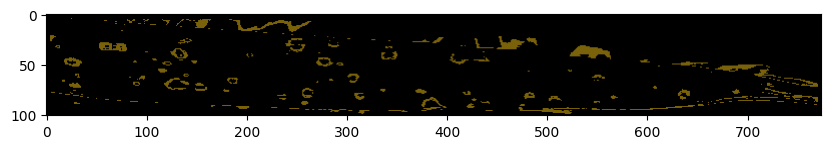

In [ ]:
reference_hsv = normalize_hsv(mean_hsv)
tolerance = 10
disease_cluster = None
best_match_score = float('inf')

for cluster_idx in range(test_K):
    cluster_pixels = mask_filter(test_image, segmented_test_image, cluster_idx, test_labels)
    cluster_pixels_hsv = cv.cvtColor(cluster_pixels, cv.COLOR_RGB2HSV)
    mean_hsv_cluster = cv.mean(cluster_pixels_hsv)[:3]

    print(mean_hsv_cluster)
    if mean_hsv_cluster == (0.0, 0.0, 0.0):
      print(f"Cluster {cluster_idx} di-skip karena nilai HSV tidak relevan: {mean_hsv_cluster}")
      continue

    score = calculate_hsv_similarity(normalize_hsv(mean_hsv_cluster), reference_hsv)

    if score < best_match_score:
        best_match_score = score
        disease_cluster = cluster_idx
        print(f"Cluster {cluster_idx} mengandung penyakit dengan mean HSV {mean_hsv_cluster}")

if disease_cluster is not None:
    print(f"Cluster penyakit terbaik ditemukan: {disease_cluster}")
    plt.figure(figsize=(10, 5))
    plt.imshow(mask_filter(test_image, segmented_test_image, disease_cluster, test_labels))
else:
    print("Cluster penyakit tidak ditemukan")

---
# Divider

# Testing
Untuk penjelasan juga, soal reference, optimal k, color dominant

(-0.5, 3080.5, 896.5, -0.5)

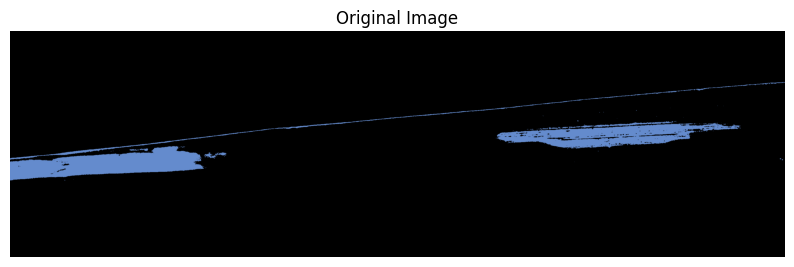

In [71]:
diseased_portion_image = mask_filter(test_image, segmented_test_image, 1, test_labels)
diseased_portion_image = cv.cvtColor(diseased_portion_image, cv.COLOR_RGB2HSV)
np.save('bacterial_leaf_blight_reference_2.npy', diseased_portion_image)
plt.figure(figsize=(10, 5))
plt.title("Original Image")
plt.imshow(diseased_portion_image)
plt.axis("off")

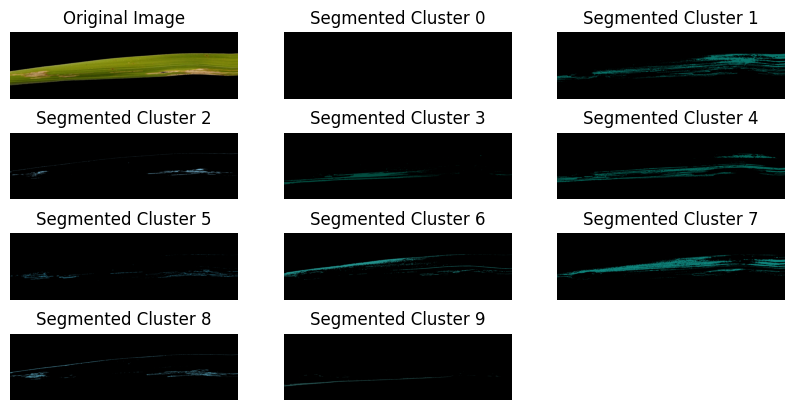

In [98]:
plt.figure(figsize=(10, 5))
plt.subplot(4, 3, 1)
plt.title("Original Image")
plt.imshow(test_image)
plt.axis("off")

for cluster in range(10):
  filtered_test_image = mask_filter(test_image, segmented_test_image, cluster, test_labels)

  plt.subplot(4, 3, cluster + 2)
  plt.title(f'Segmented Cluster {cluster}')
  plt.imshow(filtered_test_image)
  plt.axis("off")

plt.show()

In [92]:
test_image = background_remover("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Train/Bacterial Blight/6.jpg")
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

In [93]:
gaps, s_k = calculate_gap_statistic_parallel(test_image, max_k=10, n_refs=10, num_workers=2)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(gaps) + 1), gaps, marker='o', label='Gap Statistic')
plt.fill_between(range(1, len(gaps) + 1), gaps - s_k, gaps + s_k, alpha=0.2, label='Standard Error')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs K')
plt.legend()
plt.show()

In [ ]:
optimal_k = find_optimal_k(gaps, s_k)
print(f"The optimal number of clusters (K) is: {optimal_k}")

In [96]:
results = parallel_segmentation([test_image], K=10, num_workers=2)
segmented_test_image = results[0][0]
test_labels = results[0][1]
test_centers = results[0][2]

(0.0, 0.0, 0.0)
Cluster 0 di-skip karena nilai HSV tidak relevan: (0.0, 0.0, 0.0)
(5.760561820804825, 15.493924897337116, 7.879389157192807)
Cluster 1 mengandung penyakit dengan mean HSV (5.760561820804825, 15.493924897337116, 7.879389157192807)
(0.7829119170721982, 0.853373989608696, 1.5501655958029525)
Cluster 2 mengandung penyakit dengan mean HSV (0.7829119170721982, 0.853373989608696, 1.5501655958029525)
(2.4745635945415803, 7.132565654855143, 2.2707760044028618)
(4.9966475579277745, 14.118434378795921, 5.984356958913498)
(1.0318936105312635, 1.8510256518808232, 1.4467786704355858)
(2.5113094714720385, 5.474090308601972, 4.147893171981907)
(6.08972531685372, 15.639521836465235, 9.272990823390892)
Cluster penyakit terbaik ditemukan: 2


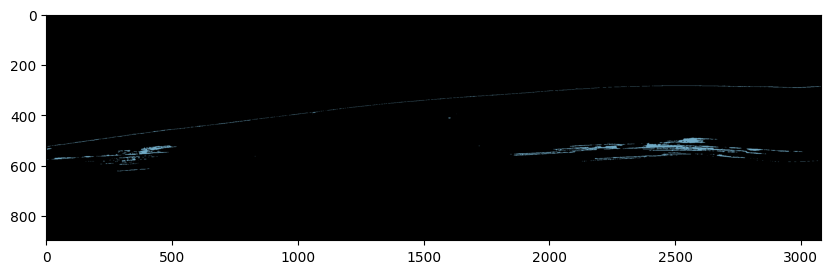

In [99]:
disease_cluster = None
best_match_score = float('inf')
for cluster_idx in range(8):
    cluster_pixels = mask_filter(test_image, segmented_test_image, cluster_idx, test_labels)
    cluster_pixels_hsv = cv.cvtColor(cluster_pixels, cv.COLOR_RGB2HSV)
    mean_hsv_cluster = cv.mean(cluster_pixels_hsv)[:3]

    print(mean_hsv_cluster)
    if mean_hsv_cluster == (0.0, 0.0, 0.0):
      print(f"Cluster {cluster_idx} di-skip karena nilai HSV tidak relevan: {mean_hsv_cluster}")
      continue

    score = calculate_hsv_similarity(normalize_hsv(mean_hsv_cluster), bacterial_blight_reference)

    if score < best_match_score:
        best_match_score = score
        disease_cluster = cluster_idx
        print(f"Cluster {cluster_idx} mengandung penyakit dengan mean HSV {mean_hsv_cluster}")

if disease_cluster is not None:
    print(f"Cluster penyakit terbaik ditemukan: {disease_cluster}")
    plt.figure(figsize=(10, 5))
    plt.imshow(mask_filter(test_image, segmented_test_image, disease_cluster, test_labels))
else:
    print("Cluster penyakit tidak ditemukan")

# Perpare Data

## Disease references

In [110]:
def get_disease_reference(disease):
  disease_reference = np.load(disease)
  disease_mean_hsv = cv.mean(disease_reference)[:3]
  disease_mean_hsv = normalize_hsv(disease_mean_hsv)

  return disease_mean_hsv

In [143]:
bacterial_blight_reference = get_disease_reference("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Reference/bacterial_blight_reference.npy")
blast_reference = get_disease_reference("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Reference/blast_reference.npy")
brownspot_reference = get_disease_reference("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Reference/brownspot_reference.npy")

reference_hsv_dict = {
    "Bacterial Blight": bacterial_blight_reference,
    "Blast": blast_reference,
    "Brownspot": brownspot_reference,
}

In [168]:
import multiprocessing
from sklearn.preprocessing import LabelEncoder
# num_cores = multiprocessing.cpu_count()

In [144]:
train_ds = get_list_of_files("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Train")
test_ds = get_list_of_files("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Test")

In [72]:
def load_image_with_path(image_path):
    img = background_remover(image_path)
    img = cv.resize(img, (150, 150), interpolation=cv.INTER_AREA)
    label = os.path.basename(os.path.dirname(image_path))
    return img, label, image_path

def prepare_data(dataset, num_workers=2):
    with multiprocessing.Pool(num_workers) as pool:
        results = pool.map(load_image_with_path, dataset)

    data = [res[0] for res in results]
    labels = [res[1] for res in results]
    paths = [res[2] for res in results]

    return np.array(data), np.array(labels), paths

In [146]:
X_train, y_train, train_paths = prepare_data(train_ds)
X_test, y_test, test_paths = prepare_data(test_ds)

# Segmenting Data

In [147]:
train_segmented_ds = parallel_segmentation(X_train, K=8, num_workers=2)
test_segmented_ds = parallel_segmentation(X_test, K=8, num_workers=2)

# Choose Right Cluster

In [155]:
def process_image(args):
    test_image, segmented_test_image, image_label, masking_labels, num_clusters, image_path = args
    best_cluster = None
    best_score = float('inf')
    best_masked_image = None

    print(image_label)
    reference_hsv = reference_hsv_dict.get(image_label, None)
    if reference_hsv is None:
        # print(f"Tidak ada referensi HSV buat {image_label}")
        return {"image_path": image_path, "best_cluster": None, "best_score": None, "masked_image": None}

    for cluster_idx in range(num_clusters):
        cluster_pixels = mask_filter(test_image, segmented_test_image, cluster_idx, masking_labels)
        cluster_pixels_hsv = cv.cvtColor(cluster_pixels, cv.COLOR_RGB2HSV)
        mean_hsv_cluster = cv.mean(cluster_pixels_hsv)[:3]

        if mean_hsv_cluster == (0.0, 0.0, 0.0):
            continue

        score = calculate_hsv_similarity(normalize_hsv(mean_hsv_cluster), reference_hsv)
        if score < best_score:
            best_cluster = cluster_idx
            best_score = score
            best_masked_image = cluster_pixels
    best_masked_image = np.array(best_masked_image)

    return {
        "image_path": image_path,
        "best_cluster": best_cluster,
        "best_score": best_score,
        "masked_image": best_masked_image
    }

def find_best_clusters(images, labels_list, segmented_images, masking_labels_list, image_paths, num_clusters=8, num_workers=2):
    args = [
        (images[i], segmented_images[i], labels_list[i], masking_labels_list[i], num_clusters, image_paths[i])
        for i in range(len(images))
    ]

    with multiprocessing.Pool(processes=num_workers) as pool:
        results = pool.map(process_image, args)

    return [result for result in results if result.get("best_cluster") is not None]

In [148]:
train_segmented_images = [result[0] for result in train_segmented_ds]
train_labels_list = [result[1] for result in train_segmented_ds]
test_segmented_images = [result[0] for result in test_segmented_ds]
test_labels_list = [result[1] for result in test_segmented_ds]

In [ ]:
train_diseased_portion_images = find_best_clusters(X_train, y_train, train_segmented_images, train_labels_list, train_paths, 8, 2)
test_diseased_portion_images = find_best_clusters(X_test, y_test, test_segmented_images, test_labels_list, test_paths, 8, 2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
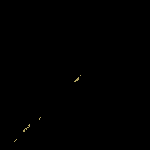

In [88]:
train_diseased_portion_images[1]["masked_image"]

(-0.5, 1740.5, 1740.5, -0.5)

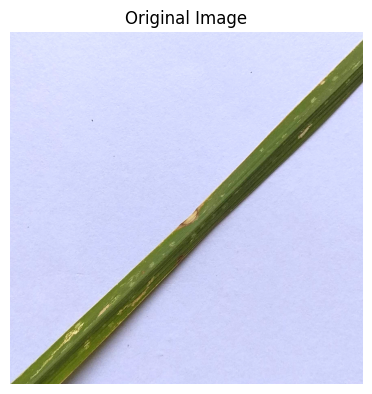

In [89]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv.cvtColor(cv.imread(train_diseased_portion_images[1]["image_path"]), cv.COLOR_BGR2RGB))
plt.axis("off")

In [157]:
X_train = [d["masked_image"] for d in train_diseased_portion_images]
X_test = [d["masked_image"] for d in test_diseased_portion_images]

# Classifier

In [151]:
from sklearn.neighbors import KNeighborsClassifier

In [152]:
knn_model = KNeighborsClassifier(n_neighbors=3)

# Training

In [167]:
X_train_flattened = np.array([img.flatten() for img in X_train])
X_train_flattened = X_train_flattened / 255.0
X_test_flattened = np.array([img.flatten() for img in X_test])
X_test_flattened = X_test_flattened / 255.0

In [169]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [172]:
knn_model.fit(X_train_flattened, y_train_encoded)

KNeighborsClassifier(n_neighbors=3)

# Evaluation

In [173]:
from sklearn.metrics import accuracy_score

In [174]:
y_pred_encoded = knn_model.predict(X_test_flattened)

y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 38.28%
